In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


environment_name = 'LunarLander-v3'
env = gym.make(environment_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.actor = nn.Linear(256, action_dim)
        self.critic = nn.Linear(256, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value

In [3]:
class PPO:
    def __init__(self, state_dim, action_dim, lr, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = ActorCritic(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        old_states = torch.stack(memory.states).detach()
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()
        
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())
    
    def evaluate(self, state, action):
        action_probs, state_value = self.policy(state)
        dist = torch.distributions.Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, state_value, dist_entropy

In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [5]:
def train(env, ppo, memory, max_episodes, max_timesteps, update_timestep):
    episode_rewards = []
    timestep = 0
    
    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for t in range(max_timesteps):
            timestep += 1
            state = torch.FloatTensor(state)
            action_probs, _ = ppo.policy_old(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
            
            next_state, reward, done, truncated, _ = env.step(action.item())
            done = done or truncated 
            
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(action_logprob)
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            
            state = next_state
            episode_reward += reward
            
            if timestep % update_timestep == 0:
                ppo.update(memory)
                memory.clear_memory()
                timestep = 0
            
            if done:
                break
                
        episode_rewards.append(episode_reward)
        if (episode+1) % 10 ==0:
            print(f'Episode: {episode + 1} Reward: {episode_reward}')
            
    return episode_rewards

In [6]:
lr = 0.0003
gamma = 0.99
K_epochs = 4
eps_clip = 0.2
max_episodes = 4000
max_timesteps = 1000
update_timestep = 1000

ppo = PPO(state_dim, action_dim, lr, gamma, K_epochs, eps_clip)
memory = Memory()

episode_rewards = train(env, ppo, memory, max_episodes, max_timesteps, update_timestep)

Episode: 10 Reward: -272.9589150494819


C:\Users\rajur\Projects\Moon Landing RL\RL_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 20 Reward: -98.12532354364313
Episode: 30 Reward: -145.0594154340147
Episode: 40 Reward: -341.73610455835944
Episode: 50 Reward: -31.630371994157386
Episode: 60 Reward: -151.1557213384811
Episode: 70 Reward: -166.1253893470317
Episode: 80 Reward: -116.32050989774238
Episode: 90 Reward: -347.24495956939387
Episode: 100 Reward: -115.81746059632093
Episode: 110 Reward: -148.452827462532
Episode: 120 Reward: -14.650120317700868
Episode: 130 Reward: -234.11292522023348
Episode: 140 Reward: -109.7248372148107
Episode: 150 Reward: -158.31065001211545
Episode: 160 Reward: -133.1629984443042
Episode: 170 Reward: -101.33112578140567
Episode: 180 Reward: 7.878944675953193
Episode: 190 Reward: -87.15435660674274
Episode: 200 Reward: -10.030159985873269
Episode: 210 Reward: -147.3162110276848
Episode: 220 Reward: 19.078537505174495
Episode: 230 Reward: -117.02700114020772
Episode: 240 Reward: -313.38096054165203
Episode: 250 Reward: -83.39867442059445
Episode: 260 Reward: -77.7910432260337

Episode: 2060 Reward: 166.91628229846742
Episode: 2070 Reward: 235.6713473763204
Episode: 2080 Reward: 36.09924791862042
Episode: 2090 Reward: 131.10423897556842
Episode: 2100 Reward: 137.1416701383851
Episode: 2110 Reward: 72.131243897649
Episode: 2120 Reward: -10.88257262620004
Episode: 2130 Reward: 116.97136396745279
Episode: 2140 Reward: 63.84887949627776
Episode: 2150 Reward: 89.59944074664813
Episode: 2160 Reward: 129.7155670342151
Episode: 2170 Reward: 154.1440874324164
Episode: 2180 Reward: 167.44079970383615
Episode: 2190 Reward: 162.13850364784548
Episode: 2200 Reward: 129.1839645941973
Episode: 2210 Reward: 148.1417709906935
Episode: 2220 Reward: 108.00337557901287
Episode: 2230 Reward: 97.0652469285643
Episode: 2240 Reward: 65.52040346394224
Episode: 2250 Reward: 151.60261958283874
Episode: 2260 Reward: 181.7604898066433
Episode: 2270 Reward: 105.64834688645554
Episode: 2280 Reward: 37.547259794198546
Episode: 2290 Reward: 134.04153328907557
Episode: 2300 Reward: 80.5702455

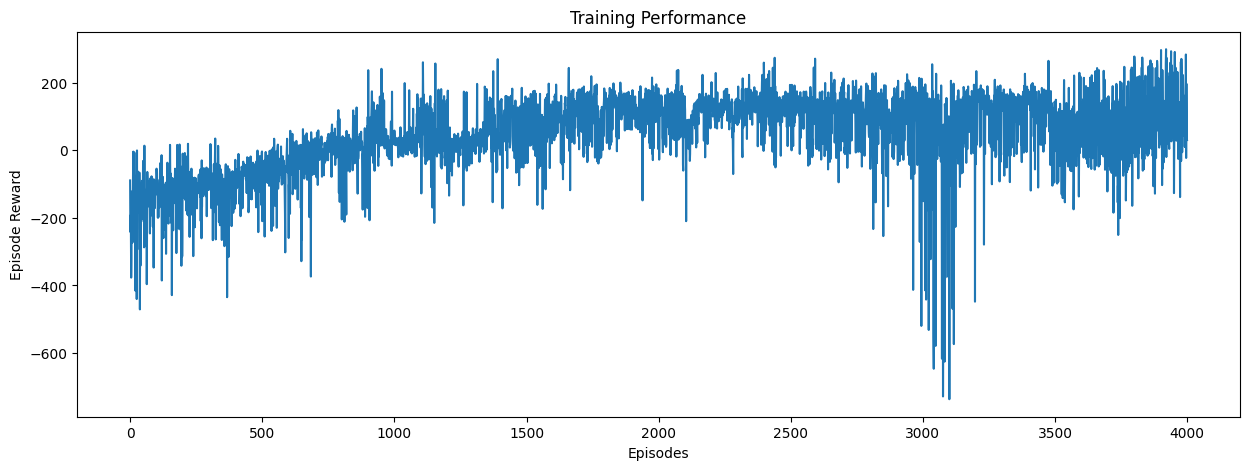

In [29]:
plt.subplots(figsize=(15, 5))
plt.plot(episode_rewards)
plt.title('Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.show()

In [8]:
def evaluate_policy(ppo, env, n_eval_episodes=10):
    rewards = []
    for _ in range(n_eval_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        while not done:
            state = torch.FloatTensor(state)
            action_probs, _ = ppo.policy(state)
            action = torch.argmax(action_probs).item()
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_policy(ppo, env)
print(f"Mean reward: {mean_reward} ± {std_reward}")

Mean reward: 181.9542461540684 ± 90.11202923877279


In [9]:
torch.save(ppo.policy.state_dict(), "Custom PPO Model.pth")

In [10]:
def test_model(model, env, n_eval_episodes=10):
    rewards = []
    model.eval()  

    for episode in range(n_eval_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs, _ = model(state_tensor)
            action = torch.argmax(action_probs).item()

            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    return np.mean(rewards), np.std(rewards)

In [13]:
env = gym.make(environment_name)
model = ActorCritic(8, 4)
model.load_state_dict(torch.load("Custom PPO Model.pth", weights_only=False))

mean_reward, std_reward = test_model(model, env)
print(f"Mean reward: {mean_reward} ± {std_reward}")

Mean reward: 171.14993904806278 ± 128.65281870329548


In [14]:
env = gym.make(environment_name,render_mode="human")
episodes = 5
for episode in range(episodes):
    n_state,_=env.reset()
    score = 0
    done = False
    while not done:
        env.render()
        state_tensor = torch.FloatTensor(n_state).unsqueeze(0)
        with torch.no_grad():
            action_probs, _ = model(state_tensor)
        action = torch.argmax(action_probs).item()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score += reward
    print(f'Episode: {episode + 1} Score: {score}')
env.close()

Episode: 1 Score: 181.3194667905439
Episode: 2 Score: 271.88286326996445
Episode: 3 Score: -119.07304892138339
Episode: 4 Score: 226.43383167178456
Episode: 5 Score: 249.8577191083427
